In [2]:
import pywt

from sigvisa.models.wiggles.wavelets import construct_wavelet_basis_full

ImportError: cannot import name construct_wavelet_basis_full

In [13]:
db4 = construct_wavelet_basis(1.0, "db4_0.5_99_64", sort=False)
haar = construct_wavelet_basis(1.0, "db1_1.0_99_64", sort=False)

orig [13, 13, 19]
appending 58 from 32
appending 110 from 58
padded [13, 13, 19, 32, 58]
constructed wavelet basis with 45 params for signal of length 110
orig [1, 1, 2, 4, 8, 16, 32]
padded [1, 1, 2, 4, 8, 16, 32]
constructed wavelet basis with 64 params for signal of length 64


In [1]:
def plot_frameless(z, figsize=(10,5), ylim=None, *args, **kwargs):
    fig = plt.figure(frameon=False, figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.plot(z, *args, **kwargs)
    if ylim is not None:
        ax.set_ylim(ylim)
    return ax


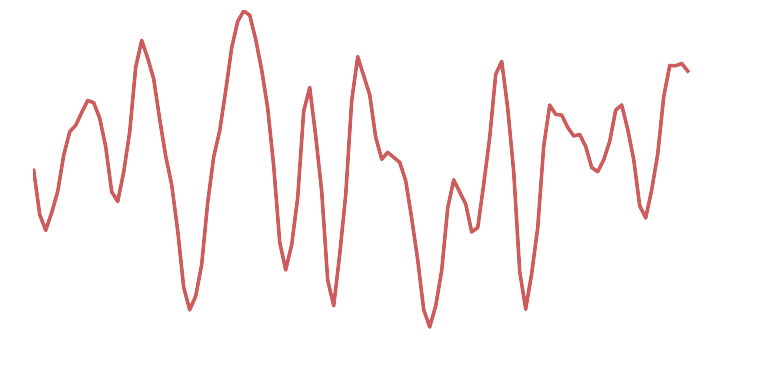

In [71]:
w = np.random.randn(45)
z = np.dot(db4.T, w)
plot_frameless(z, c="indianred", lw=4)
z_wavelet = z

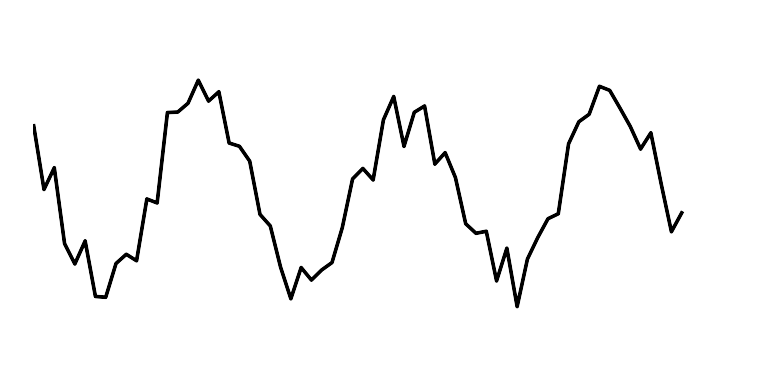

In [54]:
z = np.sin(np.linspace(-10, 10, 64)) + 0.2*np.random.randn(64)


        
plot_frameless(z, ylim=(-2,2), c="black", lw=4)

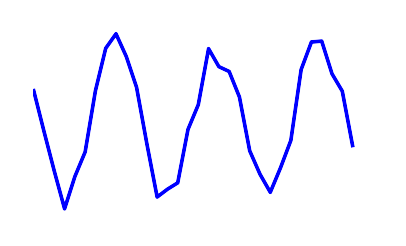

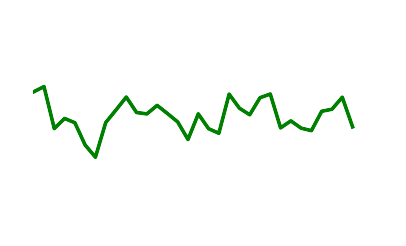

In [56]:
a1 = pywt.downcoef('a', z, 'db1', 'per')
d1 = pywt.downcoef('d', z, 'db1', 'per')

plot_frameless(a1, figsize=(5,3), ylim=(-2,2), c="blue", lw=4)

plot_frameless(d1, figsize=(5,3), ylim=(-2,2), c="green", lw=4)


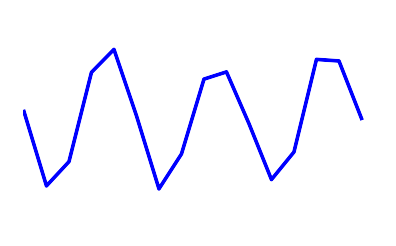

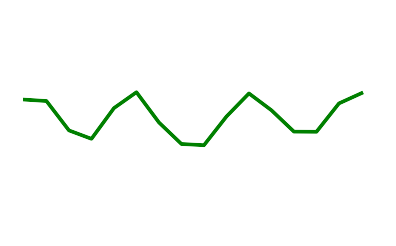

In [57]:
a2 = pywt.downcoef('a', a1, 'db1', 'per')
d2 = pywt.downcoef('d', a1, 'db1', 'per')

plot_frameless(a2, figsize=(5,3), ylim=(-3,3), c="blue", lw=4)

plot_frameless(d2, figsize=(5,3), ylim=(-3,3), c="green", lw=4)



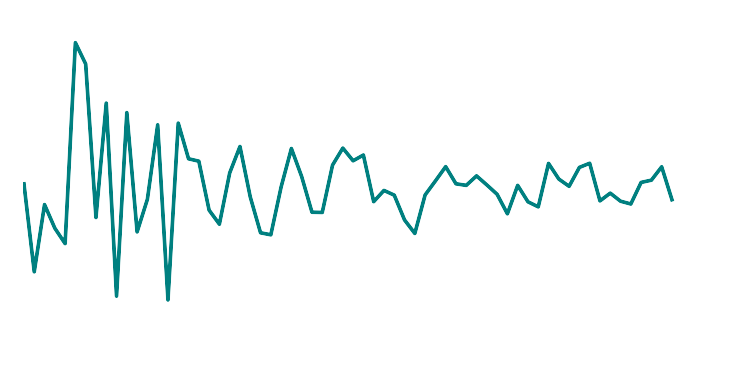

In [58]:
fulldec = pywt.wavedec(z, 'db1', 'per')
dd = np.concatenate(fulldec)


plot_frameless(dd, figsize=(10,5), ylim=(-3,3), c="teal", lw=4)


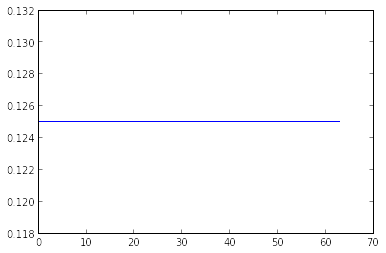

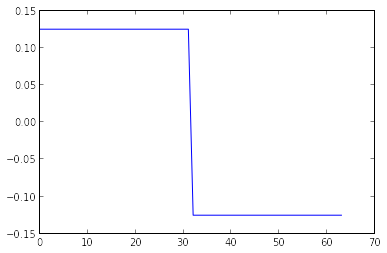

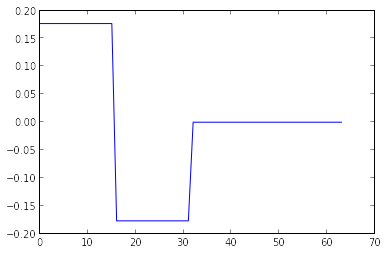

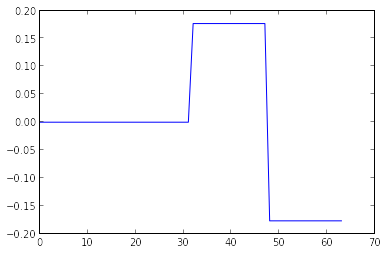

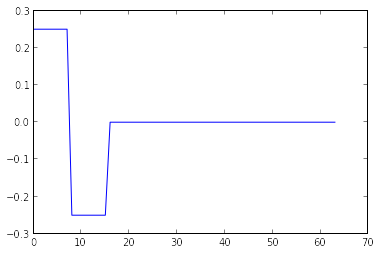

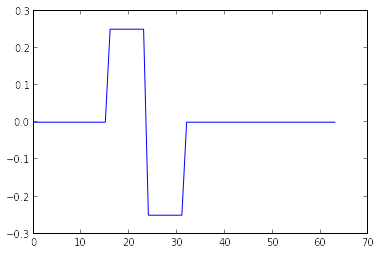

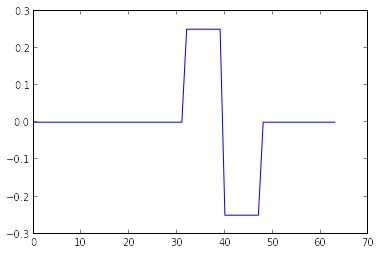

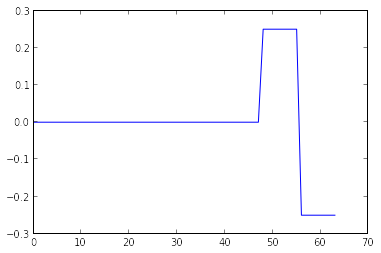

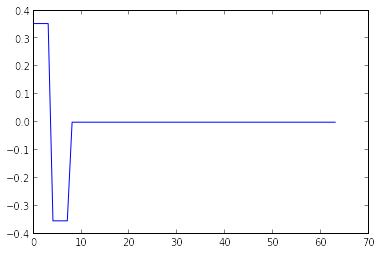

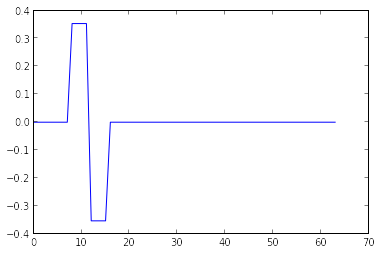

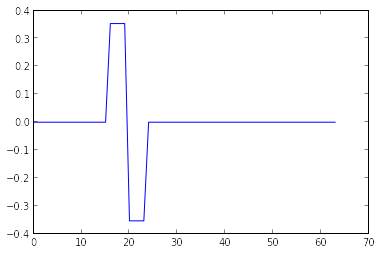

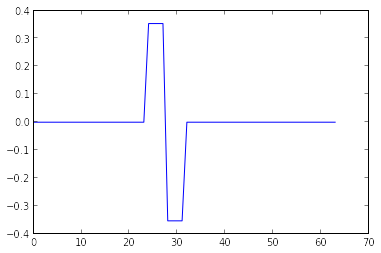

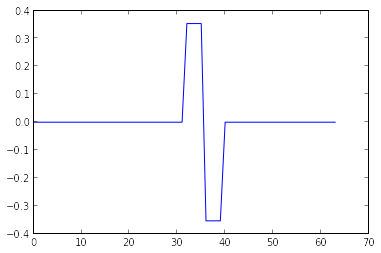

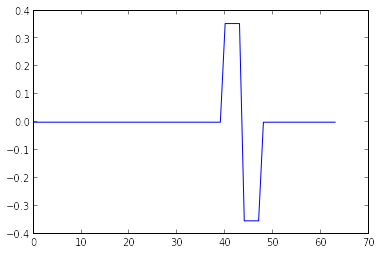

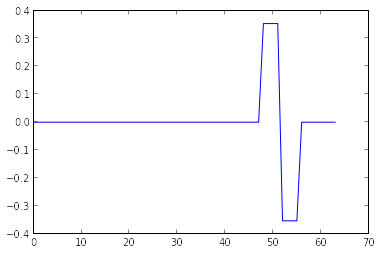

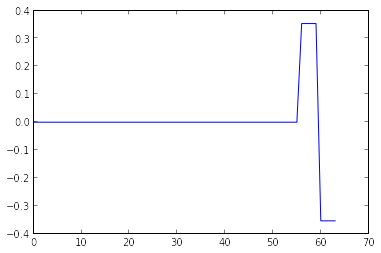

In [46]:
def construct_basis_simple(N, family, pad):
    z = np.zeros((N,))
    cc = pywt.wavedec(z, family, pad)
    nb = np.sum([len(l) for l in cc])
    basis = np.zeros((nb, N))
    k=0
    for i in range(len(cc)):
        for j in range(len(cc[i])):
            cc[i][j] = 1
            basis[k+j, :] = pywt.waverec(cc, family, pad)
            cc[i][j] = 0
        k += len(cc[i])
    return basis

haar = construct_basis_simple(64, 'db1', 'per')

for h in haar[:16]:
    figure()
    plot(h)

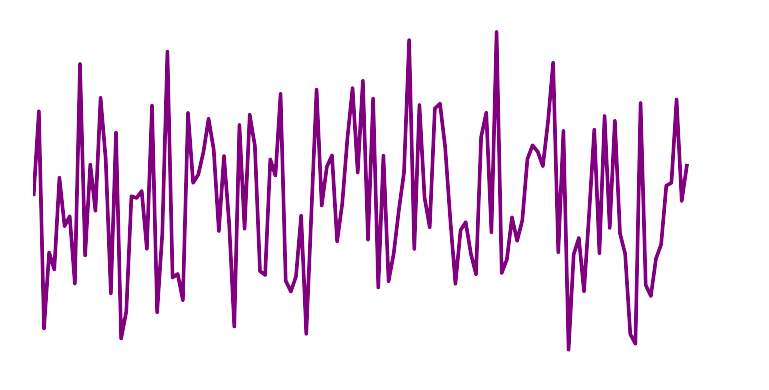

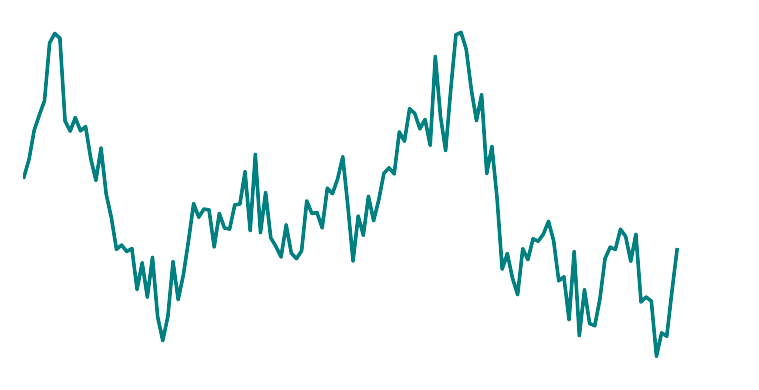

In [79]:
from sigvisa.models.noise.armodel.model import ARModel, ErrorModel

z1 = np.random.randn(128)

em = ErrorModel(mean=0, std=0.5)
arm = ARModel(params=[0.7, 0.2], em=em)
z2 = arm.sample(128)

plot_frameless(z1, figsize=(10,5), c="purple", lw=4)
plot_frameless(z2, figsize=(10,5), c="teal", lw=4)

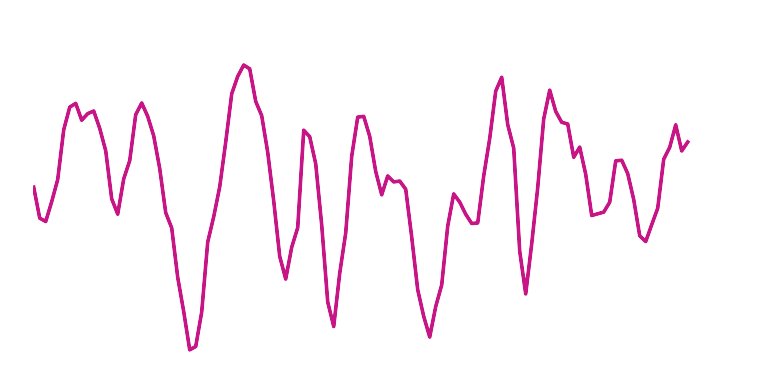

In [82]:
z_combined = 0.2*z2[:110]
z_combined[:110] += z_wavelet
plot_frameless(z_combined, figsize=(10,5), c="mediumvioletred", lw=4)

In [92]:
D = np.array(((0.0, 0.5, 3.0), (0.5, 0.0, 2.7), (3.0, 2.7, 0.0)))
K = np.exp(-D**2)
np.set_printoptions(precision=4, suppress=True)
print K

[[ 1.      0.7788  0.0001]
 [ 0.7788  1.      0.0007]
 [ 0.0001  0.0007  1.    ]]


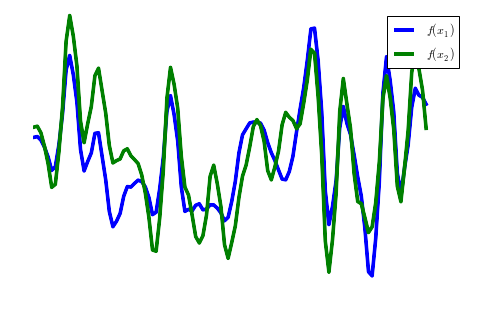

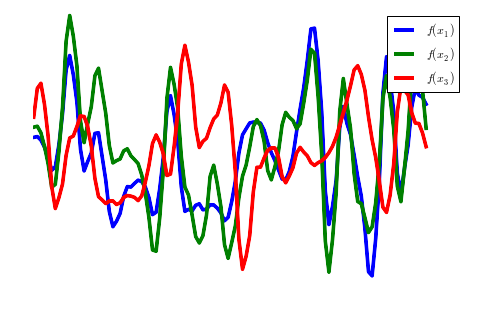

In [107]:
import scipy.stats
coefs = scipy.stats.multivariate_normal(mean=np.zeros((3,)), cov=K).rvs(45)

z1 = np.dot(db4.T, coefs[:, 0])
z2 = np.dot(db4.T, coefs[:, 1])
z3 = np.dot(db4.T, coefs[:, 2])

f = plt.figure(frameon=False)
ax=f.add_axes([0,0,1,1])
ax.axis("off")
ax.plot(z1, label="$f(x_1)$", lw=4)
ax.plot(z2, label = "$f(x_2)$", lw=4)
ax.legend()
f = plt.figure(frameon=False)
ax=f.add_axes([0,0,1,1])
ax.axis("off")
ax.plot(z1, label="$f(x_1)$", lw=4)
ax.plot(z2, label = "$f(x_2)$", lw=4)
ax.plot(z3, label = "$f(x_3)$", lw=4)

ax.legend()



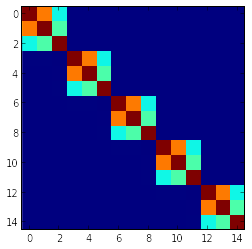

In [110]:
D = np.array(((0.0, 0.5, 1.0), (0.5, 0.0, 0.9), (1.0, 0.9, 0.0)))
K = np.exp(-D**2)
imshow(K, interpolation="none")
KK = np.kron(np.eye(5), K)
imshow(KK, interpolation="none")

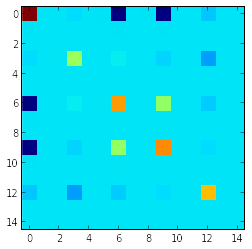

In [119]:

obs_cov = np.zeros((5,5))
for i in range(5):
    for j in range(i,5):
        obs_cov[i, j] = np.random.rand()
        obs_cov[j, i] = obs_cov[i, j]
        if i==j:
            obs_cov[i, j] += 1
            
oci = np.linalg.inv(obs_cov)
oci_puffed = np.zeros(KK.shape)
            
for i in range(5):
    for j in range(5):
        oci_puffed[3*i, 3*j] = oci[i,j]
    
imshow(oci_puffed, interpolation="none")

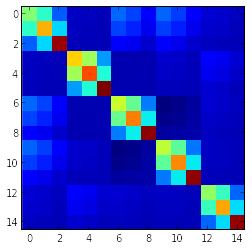

In [121]:
obsK = np.linalg.inv(np.linalg.inv(KK) + oci_puffed)
imshow(obsK,  interpolation="none")

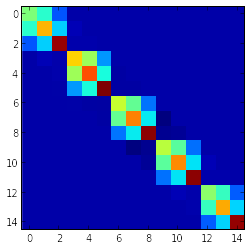

In [122]:
bdK = obsK.copy()
for i in range(obsK.shape[0]):
    for j in range(obsK.shape[1]):
        if np.abs(i-j) > 2:
            bdK[i,j]=0
imshow(bdK,  interpolation="none")            

In [2]:
from sigvisa.signals.io import load_event_station_chan
from sigvisa.models.noise.noise_util import get_noise_model
from sigvisa.models.templates.lin_polyexp import LinPolyExpTemplateGenerator
from sigvisa.models.wiggles.wavelets import construct_full_basis_implicit

w = load_event_station_chan(5335760, "MKAR", "auto", evtype="leb", pre_s = 10, post_s=200)
ww = w.filter("freq_2.0_3.0;env;hz_1.0")
armodel = get_noise_model(ww)
print armodel.c

tvals = {"arrival_time": 1240277349.81,
         "peak_offset": 1.104147,
         "coda_height": 0.355096,
         "peak_decay": -1.745213,
         "coda_decay": -2.852016,
         "amp_transfer": 1.732165}
start = (tvals['arrival_time'] - ww['stime']) * ww['srate']
start_idx = int(np.floor(start))
offset = float(start - start_idx)

log_tmpl = LinPolyExpTemplateGenerator.abstract_logenv_raw(tvals, idx_offset=offset, srate=ww['srate'])
tmpl = np.exp(log_tmpl)

#A = construct_wavelet_basis(1.0, "db4_1.0_99_60")
basis = construct_full_basis_implicit(1.0, "db4_1.0_3_60")

1240277341.42 1240277551.42
0.247715157


In [3]:
from sigvisa.ssms_c import ARSSM, CompactSupportSSM, TransientCombinedSSM

arssm = ARSSM(np.asarray(armodel.params, dtype=np.float), armodel.em.std**2, 0.0, armodel.c)

start_idxs, end_idxs, identities, basis_prototypes, levels = basis
n_basis = len(start_idxs)
prior_means = np.zeros((n_basis,))
prior_vars = np.ones((n_basis,))
cssm = CompactSupportSSM(start_idxs, end_idxs, identities, basis_prototypes, prior_means, prior_vars, 0.0, 0.0)


npts = len(tmpl)
#components = [(arssm, 0, 1000, None), (cssm, start_idx, 60, tmpl), (None, start_idx, len(tmpl), tmpl)]
components = [(arssm, 0, 1000, None), ]

tssm = TransientCombinedSSM(components, 1e-4)



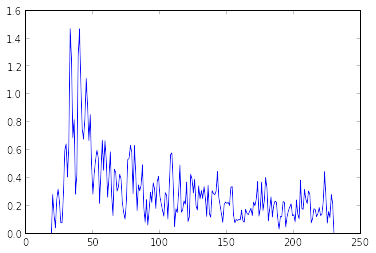

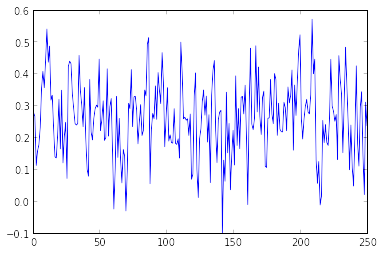

In [4]:
d = ww.data.data
d[ww.data.mask] = 0
plot(d)
target = np.asarray(d[:150], dtype=np.float64)
figure()
plot(tssm.prior_sample(len(ww.data), 0))

In [ ]:
means = tssm.component_means(target)

In [5]:
wavelet_mean = np.load("/home/dmoore/python/sigvisa/means1.npy")
noise_mean = np.load("/home/dmoore/python/sigvisa/means0.npy")
wavelet_var = np.load("/home/dmoore/python/sigvisa/vars1.npy")
noise_var = np.load("/home/dmoore/python/sigvisa/vars0.npy")

noise_mean = noise_mean[:len(ww.data)]
noise_var = noise_var[:len(ww.data)]

In [9]:
len(noise_mean)

1000

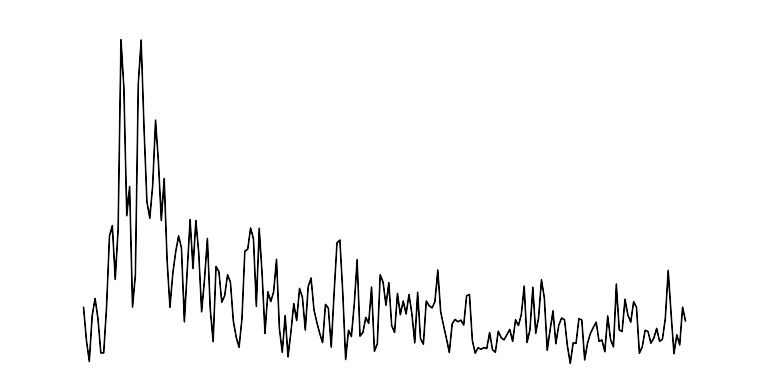

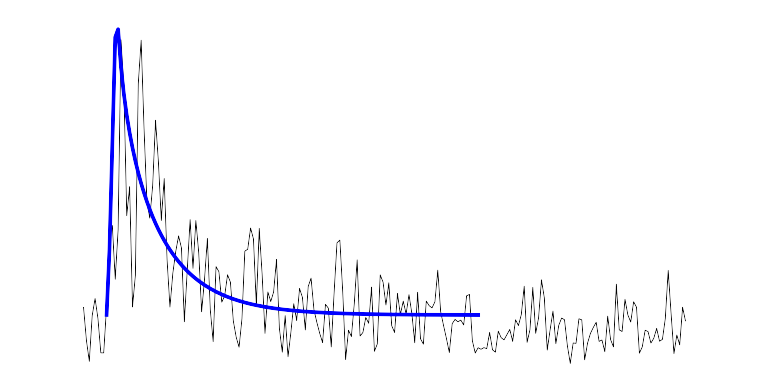

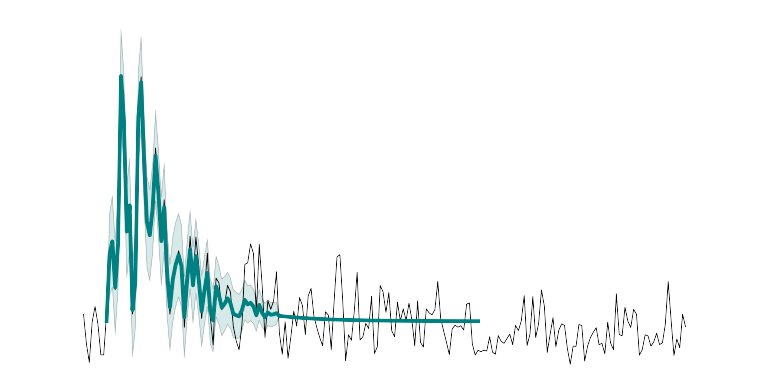

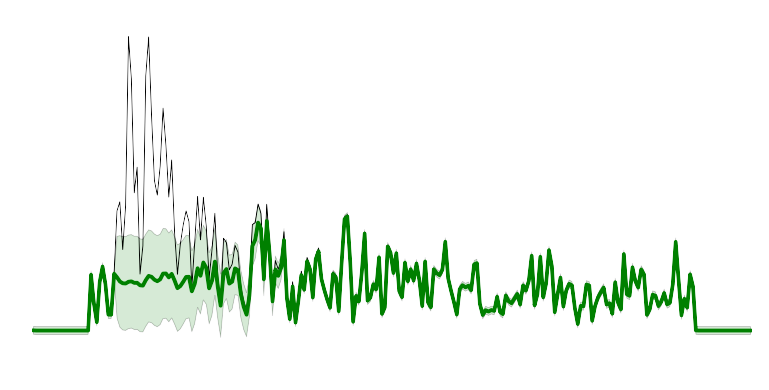

In [8]:
ax = plot_frameless(ww.data, figsize=(10,5), c="black", lw=2)



ax = plot_frameless(ww.data, figsize=(10,5), c="black", lw=1)
ax.plot(np.arange(len(ww.data))[start_idx:start_idx+len(tmpl)], tmpl+armodel.c, lw=4, c="blue")

ax = plot_frameless(ww.data, figsize=(10,5), c="black", lw=1)
pred = tmpl.copy()
pred[:len(wavelet_mean)] += tmpl[:len(wavelet_mean)]*wavelet_mean
predv = np.zeros(tmpl.shape)
predv[:len(wavelet_mean)] = tmpl[:len(wavelet_mean)]*np.sqrt(wavelet_var)*2

x_pred = np.arange(len(ww.data))[start_idx:start_idx+len(tmpl)]


ax.plot(x_pred, pred+armodel.c, c='teal', lw=4)
x_noise = np.arange(len(noise_mean))
ax.fill_between(x_pred, pred+armodel.c-predv, pred+armodel.c+predv, facecolor="teal", alpha=0.4)


ax = plot_frameless(ww.data, figsize=(10,5), c="black", lw=1)
ax.plot(noise_mean, c='green', lw=4)

x_noise = np.arange(len(noise_mean))
ax.fill_between(x_noise, noise_mean - 2*np.sqrt(noise_var), noise_mean + 2*np.sqrt(noise_var), facecolor="green", alpha=0.4)
ax.set_ylim()

In [13]:
noise_var

array([  9.91766690e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.91775765e-05,   9.91775765e-05,
         9.91775765e-05,   9.99954281e-05,   1.05423913e-02,
         1.31651286e-02,   1.37006059e-02,   1.37785523e-02,
         1.37500976e-02,   1.37063206e-02,   1.36573564e-02,
         1.36033606e-02,   1.35434141e-02,   1.34765354e-02,
         1.34017483e-02,   1.33180622e-02,   1.32244574e-02,
         1.31198806e-02,   1.30032466e-02,   1.28734477e-02,
         1.27293674e-02,   1.25699001e-02,   1.23939762e-02,
         1.22005919e-02,

521
1000


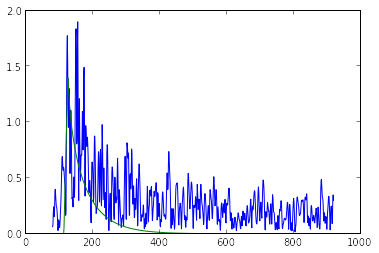

In [168]:
plot(ww.data)

print len(tmpl)
print len(ww.data)
plot(np.arange(len(ww.data))[start_idx:start_idx+len(tmpl)], tmpl)